# **Racing Data Analysis Project**

Our primary goal is to analyze and determine which cars dominate on specific tracks and identify the most versatile vehicles.

For 50 laps we will got that assess system:

1. 1st place: 10 points + 3 bonuses = 13 points
2. 2nd place: 9 points + 2 bonuses = 11 points
3. 3rd place: 8 points + 1 bonus = 9 points
4. 4th place: 7 points
5. 5th place: 6 points
6. 6th place: 5 points
7. 7th place: 4 points
8. 8th place: 3 points
9. 9th place: 2 points
10. 10th place: 1 point

**Race Length Accounting**

Determine the base length of the race (eg 50 laps).<br>
If the race is longer, for example 64 laps, the points are multiplied by a factor (64/50).<br>
If the race is shorter, for example 42 laps, the points are multiplied by a factor (42/50).<br>
So, if a win is worth 13 points in a 50-lap race, in a 64-lap race it will be worth 13 * (64/50) = 16.64 points.

## **1. Load Libraries**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

## **2. Load Data**

In [2]:
df = pd.read_parquet(".\\cleaned_data\\race_data.parquet")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7319 entries, 0 to 7318
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype          
---  ------                --------------  -----          
 0   Season                7319 non-null   int64          
 1   Meeting               7319 non-null   object         
 2   Event name            7319 non-null   object         
 3   Pos                   7319 non-null   int64          
 4   Car #                 7319 non-null   int64          
 5   Class                 7319 non-null   category       
 6   Special Class         7319 non-null   bool           
 7   Drivers               7319 non-null   object         
 8   Team                  7319 non-null   object         
 9   Car                   7319 non-null   object         
 10  Best lap set          7319 non-null   bool           
 11  Time                  7319 non-null   object         
 12  Time timedelta        7319 non-null   timedelta64[ns]
 13  Lap

In [3]:
categories_order = df['Class'].cat.categories

print(categories_order)

Index(['Invitational', 'Am Cup', 'Bronze Cup', 'Pro-Am Cup', 'Silver Cup',
       'Gold Cup', 'Pro Cup'],
      dtype='object')


In [4]:
is_ordered = df['Class'].cat.ordered

print("Is the 'Class' column ordered?" , is_ordered)

Is the 'Class' column ordered? True


In [5]:
df[(df['Season'] == 2021) & (df['Meeting'] == 'Monza') & (df['Pos'] == 1)]['Event name'].value_counts()

Event name
Main Race                     1
Main Race after 1.30 hour     1
Main Race after 2.30 hours    1
Name: count, dtype: int64

In [6]:
df[(df['Season'] == 2021) & (df['Meeting'] == 'Monza') & (df['Event name'] == 'Main Race') & (df['Pos'] == 1)]['Laps'].value_counts()

Laps
79    1
Name: count, dtype: int64

-----------------------------------

## Best by Points
Add Points column

In [7]:
# Definition of the point system
points_system = {1: 15, 2: 12, 3: 10, 4: 7, 5: 6, 6: 5, 7: 4, 8: 3, 9: 2, 10: 1}

# Function to assign points based on position
def assign_points(pos, laps, base_laps=50):
    base_points = points_system.get(pos, 0)
    lap_factor = laps / base_laps
    return base_points * lap_factor

# Adding a 'Points' column to the DataFrame
df['Points'] = df.apply(lambda row: assign_points(row['Pos'], row['Laps']), axis=1)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7319 entries, 0 to 7318
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype          
---  ------                --------------  -----          
 0   Season                7319 non-null   int64          
 1   Meeting               7319 non-null   object         
 2   Event name            7319 non-null   object         
 3   Pos                   7319 non-null   int64          
 4   Car #                 7319 non-null   int64          
 5   Class                 7319 non-null   category       
 6   Special Class         7319 non-null   bool           
 7   Drivers               7319 non-null   object         
 8   Team                  7319 non-null   object         
 9   Car                   7319 non-null   object         
 10  Best lap set          7319 non-null   bool           
 11  Time                  7319 non-null   object         
 12  Time timedelta        7319 non-null   timedelta64[ns]
 13  Lap

In [9]:
df[df['Season'] == 2023]['Meeting'].unique()

array(['Barcelona', 'Brands Hatch', 'Circuit Paul Ricard 1000Km',
       'CrowdStrike 24 Hours of Spa', 'Hockenheim', 'Misano', 'Monza',
       'Nürburgring', 'Valencia', 'Zandvoort'], dtype=object)

In [10]:
filtered_data = df[(df['Meeting'] == 'CrowdStrike 24 Hours of Spa') & (df['Season'] == 2023)]
total_points_by_car = filtered_data.groupby('Car')['Points'].sum().sort_values(ascending=False).reset_index()
total_points_by_car

,Car,Points
0,Audi R8 LMS GT3 EVO 2,2582.94
1,BMW M4 GT3,2431.52
2,Porsche 911 GT3 R (992),1580.96
3,Mercedes-AMG GT3,1561.62
4,McLaren 720S GT3 EVO,243.58
5,Ferrari 296 GT3,117.26
6,Lamborghini Huracan GT3 EVO 2,60.42
7,Aston Martin Vantage GT3,0.00
8,Ferrari 488 GT3,0.00
9,Porsche 911 GT3-R (991.II),0.00


In [26]:
print(df['Pos'].mean())

#df.to_csv('C:\\Users\\ireev\\Desktop\\cleaned_race_data_v2.csv', index=False)

df.groupby('Meeting')['Pos'].max().sort_values(ascending=False).reset_index()

28.25058068042082


,Meeting,Pos
0,CrowdStrike 24 Hours of Spa,70
1,TotalEnergies 24 Hours of Spa,66
2,Circuit Paul Ricard 1000Km,56
3,Barcelona,54
4,Nürburgring,54
5,Monza,53
6,Imola,49
7,Hockenheim,48
8,Misano,37
9,Valencia,36


---------------------


In [12]:
# Подготовка датафрейма для хранения общих результатов
df_total_points = pd.DataFrame()

# Получение уникальных трасс и сезонов
unique_tracks = df['Meeting'].unique()
unique_seasons = df['Season'].unique()

# Цикл по всем сезонам и трассам для расчета баллов
for season in unique_seasons:
    for track in unique_tracks:
        # Фильтрация данных для конкретной трассы и сезона
        filtered_data = df[(df['Meeting'] == track) & (df['Season'] == season)]
        
        # Проверка, есть ли данные для данной трассы и сезона
        if not filtered_data.empty:
            # Расчет и суммирование баллов
            points_by_car = filtered_data.groupby('Car')['Points'].sum().sort_values(ascending=False).reset_index()
            
            # Добавление информации о трассе и сезоне
            points_by_car['Meeting'] = track
            points_by_car['Season'] = season
            
            # Сохранение результатов в общем датафрейме
            df_total_points = pd.concat([df_total_points, points_by_car])

# Сброс индекса в итоговом датафрейме
df_total_points.reset_index(drop=True, inplace=True)

# Отображение итогового датафрейма
df_total_points.head()


,Car,Points,Meeting,Season
0,Mercedes-AMG GT3,103.90,Barcelona,2021
1,Porsche 911 GT3-R (991.II),65.44,Barcelona,2021
2,Lamborghini Huracan GT3 Evo,49.20,Barcelona,2021
3,Audi R8 LMS GT3,34.96,Barcelona,2021
4,Ferrari 488 GT3,30.04,Barcelona,2021


In [13]:
filtered_data = df_total_points[df_total_points['Season'] == 2023]
best_cars = filtered_data.groupby('Car')['Points'].sum().sort_values(ascending=False).reset_index()
best_cars

,Car,Points
0,Audi R8 LMS GT3 EVO 2,3081.72
1,BMW M4 GT3,2984.22
2,Mercedes-AMG GT3,1925.56
3,Porsche 911 GT3 R (992),1674.94
4,Ferrari 296 GT3,400.46
5,McLaren 720S GT3 EVO,262.60
6,Mercedes-AMG GT3 EVO,244.42
7,Lamborghini Huracan GT3 EVO 2,153.20
8,Aston Martin Vantage GT3,0.00
9,Ferrari 488 GT3,0.00


Define overall lider/s by points it's not really suitable. Because some race tracks has more racing events than others, such as on Spa. And this may skew our data.

## Best on Barcelona

In [14]:
barcelona_data = df_total_points[(df_total_points['Season'] == 2023) & (df_total_points['Meeting'] == 'Barcelona')].groupby('Car')['Points'].sum().sort_values(ascending=False).reset_index()
barcelona_data

,Car,Points
0,Ferrari 296 GT3,65.38
1,Mercedes-AMG GT3 EVO,57.18
2,Porsche 911 GT3 R (992),36.74
3,McLaren 720S GT3 EVO,8.10
4,Audi R8 LMS GT3 EVO 2,4.46
5,BMW M4 GT3,3.64
6,Aston Martin Vantage GT3,0.00
7,Lamborghini Huracan GT3 EVO 2,0.00
8,Mercedes-AMG GT3,0.00


Let's provide some statistical test/s to see if there is some statistically significant leader/s. Good options for us are ANOVA and Tukey Test.

### Hypothesis testing

Before conduct an ANOVA test, lest check out if we meet that assumptions:

* Normality of data distribution in groups - the data in each group should be approximately normally distributed.
* Homogeneity of variances - variances in groups should be approximately equal.

In [15]:
# Shapiro-Wilk test for normality

shapiro_test = stats.shapiro(barcelona_data['Points'])
print("Shapiro-Wilk test statistic:", shapiro_test.statistic)
print("Shapiro-Wilk test p-value:", shapiro_test.pvalue)

Shapiro-Wilk test statistic: 0.7522753477096558
Shapiro-Wilk test p-value: 0.005761212203651667


Это база

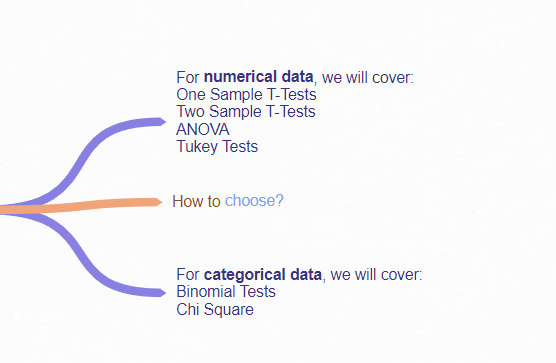 

### Hypothesis testing

Before conduct an ANOVA test, lest check out if we meet that assumptions:

* Normality of data distribution in groups - the data in each group should be approximately normally distributed.
* Homogeneity of variances - variances in groups should be approximately equal.

## Best on Spa

In [16]:
filtered_data = df_total_points[(df_total_points['Season'] == 2023) & (df_total_points['Meeting'] == 'CrowdStrike 24 Hours of Spa')]
best_cars = filtered_data.groupby('Car')['Points'].sum().sort_values(ascending=False).reset_index()
best_cars

,Car,Points
0,Audi R8 LMS GT3 EVO 2,2582.94
1,BMW M4 GT3,2431.52
2,Porsche 911 GT3 R (992),1580.96
3,Mercedes-AMG GT3,1561.62
4,McLaren 720S GT3 EVO,243.58
5,Ferrari 296 GT3,117.26
6,Lamborghini Huracan GT3 EVO 2,60.42
7,Aston Martin Vantage GT3,0.00
8,Ferrari 488 GT3,0.00
9,Porsche 911 GT3-R (991.II),0.00


`Make an ANOVA test and pairwise_tukeyhsd for all RaceTracks to know if there is a Outperforming car`